# Text mining project

Sentiment analysis of restaurant reviews

The goal will be to predict the rating people put based on their review comment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("./Restaurant reviews.csv")
dataset.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


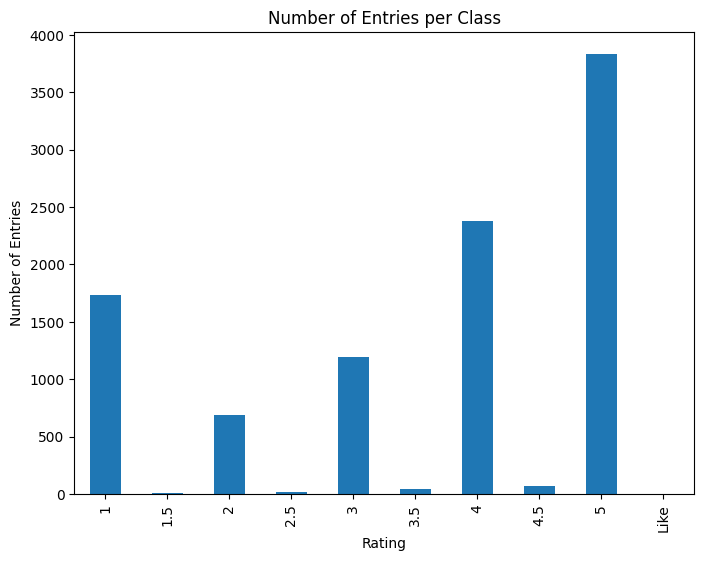

In [3]:
plt.figure(figsize=(8, 6))
dataset['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Entries per Class')
plt.xlabel('Rating')
plt.ylabel('Number of Entries')
plt.show()

## Utility functions

### Metrics display

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

def metrics(y_test, y_pred, show=True):
    """
    Calculate and optionnally display some information about the prediction results.

    Parameters:
    - y_test: actual value of the rating
    - y_pred: predicted value of the rating
    - show: wether to show or not the metrics

    Returns:
    - Precision per class
    - Recall per class
    - F1 Score per class
    - Weighted F1 score
    """
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=range(1, 6)).plot(values_format='d')
    plt.show()

    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Precision per class:\n", precision_per_class)
    print("Recall per class:\n", recall_per_class)
    print("F1 Score per class:\n", f1_per_class)
    print("Weighted F1 Score:", weighted_f1)

    return precision_per_class, recall_per_class, f1_per_class, weighted_f1

### Resampling of the dataset

In [5]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

def oversample_dataset(X, y):
    """
    Generates an oversampled dataset using RandomOverSampler.

    Parameters:
    - X: Features of the original dataset
    - y: Labels of the original dataset

    Returns:
    - X_resampled: Oversampled features
    - y_resampled: Oversampled labels
    """
    oversampler = RandomOverSampler(random_state=10)
    return oversampler.fit_resample(X, y)

def undersample_dataset(X, y):
    """
    Generates an undersampled dataset using RandomUnderSampler.

    Parameters:
    - X: Features of the original dataset
    - y: Labels of the original dataset

    Returns:
    - X_resampled: Undersampled features
    - y_resampled: Undersampled labels
    """
    undersampler = RandomUnderSampler(random_state=10)
    return undersampler.fit_resample(X, y)

def hybrid_resampling(X, y):
    """
    Generates a hybrid resampled dataset using SMOTE-ENN (a combination of over-sampling and under-sampling).

    Parameters:
    - X: Features of the original dataset
    - y: Labels of the original dataset

    Returns:
    - X_resampled: Resampled features
    - y_resampled: Resampled labels
    """
    smoteenn = SMOTEENN(random_state=10)
    X_resampled, y_resampled = smoteenn.fit_resample(X, y)
    return X_resampled, y_resampled

### Splitting the dataset

In [6]:
import random

def split_dataset(X, y, train_ratio = 0.8):
    """
    Splits the dataset into two groups: training data and test data

    Parameters:
    - X: Features of the original dataset
    - y: Labels of the original dataset
    - train_ratio: Proportion of the original dataset to put in the training data

    Returns:
    - X_train: Training data features
    - y_train: Training data labels
    - X_test: Test data features
    - y_test: Test data labels
    """
    random.seed(10)
    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined)
    train_len = int(len(X) * train_ratio)
    X_train, y_train = X[:train_len], y[:train_len]
    X_test, y_test = X[train_len:], y[train_len:]
    return X_train, y_train, X_test, y_test

def split_dataset_dev(X, y, train_ratio = 0.7, dev_ratio = 0.2):
    """
    Splits the dataset into two groups: training data and test data

    Parameters:
    - X: Features of the original dataset
    - y: Labels of the original dataset
    - train_ratio: Proportion of the original dataset to put in the training data
    - dev_ratio: Proportion of the original dataset to put in the dev data

    Returns:
    - X_train: Training data features
    - y_train: Training data labels
    - X_test: Test data features
    - y_test: Test data labels
    - X_dev: Test data features
    - y_dev: Test data labels
    """
    random.seed(10)
    assert train_ratio + dev_ratio < 1.0, "The total ratio should be < 1"
    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined)
    train_len = int(len(X) * train_ratio)
    dev_len = int(len(X) * dev_ratio)
    X_train, y_train = X[:train_len], y[:train_len]
    X_dev, y_dev = X[train_len:train_len+dev_len], y[train_len:train_len+dev_len]
    X_test, y_test = X[train_len+dev_len:], y[train_len+dev_len:]
    return X_train, y_train, X_test, y_test, X_dev, y_dev

### Error analysis

In [7]:
def create_error_analysis_file(X_test, y_test, y_pred, file_name='./error.csv'):
    """
    Creates a csv file with the incorrect predictions

    Parameters:
    - X_test: Test data features
    - y_test: Test data labels
    - y_pred: Predicted labels
    - file_name: Name of the file to save to
    """
    with open(file_name, mode="w", encoding="utf-8") as f:
        f.write("Predicted label, Actual label, Review\n")
        for xt, yt, yp in zip(X_test, y_test, y_pred):
            if yt != yp:
                xt = f"\"{xt}\""
                f.write(f"{yp}, {yt}, {xt}\n")

## Naive Bayes

- preprocess dataset with spacy
- vectorize with count vectorizer
- test with multiple resamplings

In [47]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
nlp.tokenizer = Tokenizer(nlp.vocab)

In [48]:
# Preprocess documents
from concurrent.futures import ProcessPoolExecutor

def preprocess_documents(docs, batch_size=8):
    documents = []
    for i in range(0, len(docs), batch_size):
        batch = [str(d) for d in docs[i:i + batch_size]]
        nlpdocs = list(nlp.pipe(batch))
        documents += [' '.join([tok.lemma_ for tok in d if not tok.is_stop and tok.is_alpha]) for d in nlpdocs]
    return documents
documents = preprocess_documents(dataset["Review"])

In [16]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(documents).toarray()

In [17]:
# Preprocess ratings
y = []
for i in dataset["Rating"]:
    if str(i) == "nan":
        i = "1"
    if i == "Like":
        i = "5"
    y.append(int(float(i)))

In [18]:
assert len(y) == len(X), "X and y should have the same size"
print(len(X))

10000


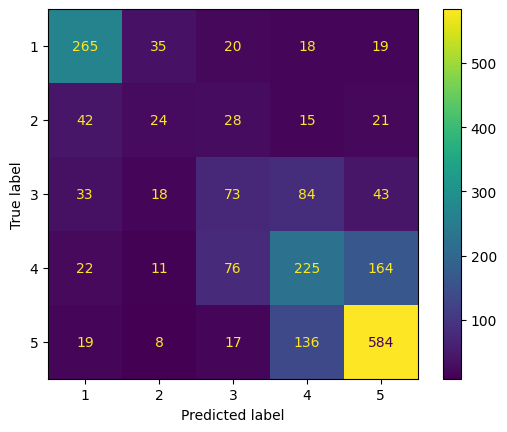

Precision per class:
 [0.69553806 0.25       0.3411215  0.4707113  0.70276775]
Recall per class:
 [0.74229692 0.18461538 0.29083665 0.45180723 0.76439791]
F1 Score per class:
 [0.71815718 0.21238938 0.31397849 0.46106557 0.7322884 ]
Weighted F1 Score: 0.5759401648682005


(array([0.69553806, 0.25      , 0.3411215 , 0.4707113 , 0.70276775]),
 array([0.74229692, 0.18461538, 0.29083665, 0.45180723, 0.76439791]),
 array([0.71815718, 0.21238938, 0.31397849, 0.46106557, 0.7322884 ]),
 0.5759401648682005)

In [19]:
from sklearn.naive_bayes import MultinomialNB
X_train, y_train, X_test, y_test = split_dataset(X, y)
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

metrics(y_test, y_pred)

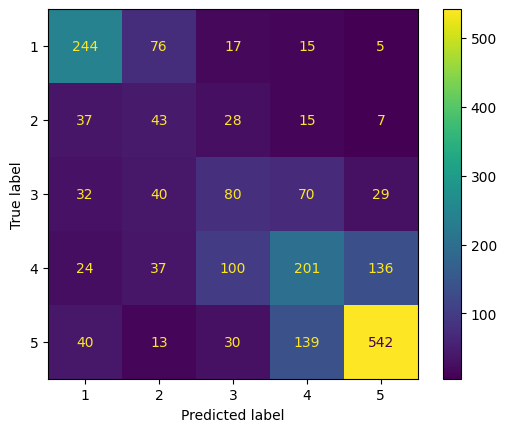

Precision per class:
 [0.64721485 0.20574163 0.31372549 0.45681818 0.75382476]
Recall per class:
 [0.68347339 0.33076923 0.3187251  0.40361446 0.70942408]
F1 Score per class:
 [0.66485014 0.25368732 0.31620553 0.42857143 0.73095078]
Weighted F1 Score: 0.5607867012395846


(array([0.64721485, 0.20574163, 0.31372549, 0.45681818, 0.75382476]),
 array([0.68347339, 0.33076923, 0.3187251 , 0.40361446, 0.70942408]),
 array([0.66485014, 0.25368732, 0.31620553, 0.42857143, 0.73095078]),
 0.5607867012395846)

In [20]:
X_train_oversampled, y_train_oversampled = oversample_dataset(X_train, y_train)
classifier_over = MultinomialNB(alpha=0.1)
classifier_over.fit(X_train_oversampled, y_train_oversampled)
y_pred = classifier_over.predict(X_test)

metrics(y_test, y_pred)

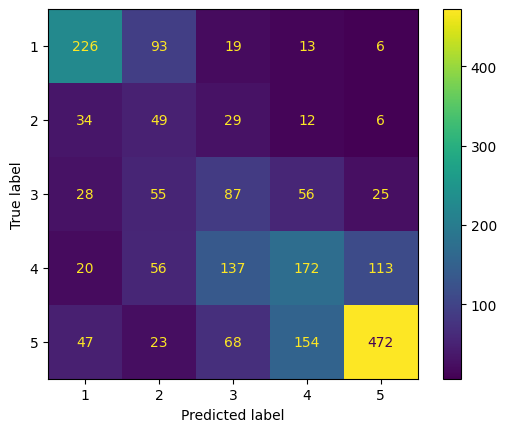

Precision per class:
 [0.63661972 0.17753623 0.25588235 0.42260442 0.75884244]
Recall per class:
 [0.63305322 0.37692308 0.34661355 0.34538153 0.61780105]
F1 Score per class:
 [0.63483146 0.24137931 0.29441624 0.3801105  0.68109668]
Weighted F1 Score: 0.520782755472518


(array([0.63661972, 0.17753623, 0.25588235, 0.42260442, 0.75884244]),
 array([0.63305322, 0.37692308, 0.34661355, 0.34538153, 0.61780105]),
 array([0.63483146, 0.24137931, 0.29441624, 0.3801105 , 0.68109668]),
 0.520782755472518)

In [21]:
X_train_undersampled, y_train_undersampled = undersample_dataset(X_train, y_train)
classifier_under = MultinomialNB(alpha=0.1)
classifier_under.fit(X_train_undersampled, y_train_undersampled)
y_pred = classifier_under.predict(X_test)

metrics(y_test, y_pred)

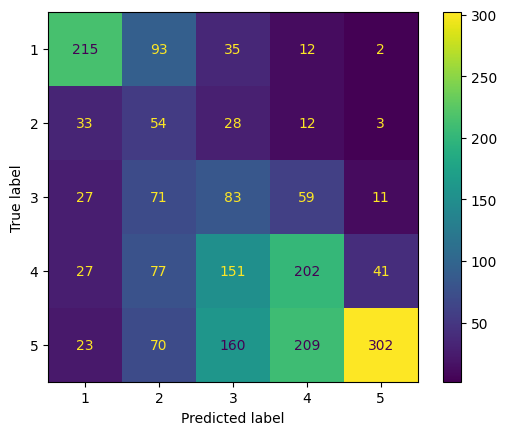

Precision per class:
 [0.66153846 0.14794521 0.18161926 0.40890688 0.84122563]
Recall per class:
 [0.6022409  0.41538462 0.33067729 0.40562249 0.39528796]
F1 Score per class:
 [0.63049853 0.21818182 0.23446328 0.40725806 0.53784506]
Weighted F1 Score: 0.4630150178694854


(array([0.66153846, 0.14794521, 0.18161926, 0.40890688, 0.84122563]),
 array([0.6022409 , 0.41538462, 0.33067729, 0.40562249, 0.39528796]),
 array([0.63049853, 0.21818182, 0.23446328, 0.40725806, 0.53784506]),
 0.4630150178694854)

In [22]:
X_train_eqsampled, y_train_eqsampled = hybrid_resampling(X_train, y_train)
classifier_eq = MultinomialNB(alpha=0.1)
classifier_eq.fit(X_train_eqsampled, y_train_eqsampled)
y_pred = classifier_eq.predict(X_test)

metrics(y_test, y_pred)

## Bert

In [8]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm
import os

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [9]:
class ClassifierHelper:
    def __init__(self, model_name, Tokenizer, Model, n_epoch=3, batch_size=16, device=None):
        self.model_name = model_name
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.path = None
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device(device)
        print("using", device)
        self.tokenizer = Tokenizer.from_pretrained(self.model_name)
        self.model = Model.from_pretrained(self.model_name, num_labels=5)
        self.optimizer = torch.optim.AdamW(params=self.model.parameters(), lr=2e-5)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model.to(self.device)

    def save(self, path=None):
        if path is not None:
            self.path = path
        elif self.path is None:
            self.path = f"bert_bs{self.batch_size}_e{self.n_epoch}.pt"
        torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict()
            }, self.path)

    def load(self, path=None):
        if path is not None:
            self.path = path
        elif self.path is None:
            self.path = f"{self.model_name}_bs{self.batch_size}_e{self.n_epoch}.pt"
            
        if os.path.exists(self.path):
            cp = torch.load(self.path)
            self.model.load_state_dict(cp['model_state_dict'])
            self.optimizer.load_state_dict(cp['optimizer_state_dict'])
            return True
        else:
            return False
    
    def load_or_train(self, path, X_train, y_train, save=True):
        if not self.load(path):
            self.train(X_train, y_train, save)
    
    def train(self, X_train, y_train, save=False):
        train_encodings = self.tokenizer(list(X_train), truncation=True, padding=True, max_length=256, return_tensors='pt')
        train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train, dtype=torch.long))
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.n_epoch):
            self.model.train()
            total_loss = 0
            for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{self.n_epoch}'):
                input_ids, attention_mask, labels = [t.to(self.device) for t in batch]
                self.optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                self.optimizer.step()
            average_loss = total_loss / len(train_loader)
            print(f'Training Loss: {average_loss}')
        if save:
            self.save()

    def evaluate(self, X_test, y_test, save_error=""):
        self.model.eval()  
        test_encodings = self.tokenizer(list(X_test), truncation=True, padding=True, max_length=256, return_tensors='pt')
        test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test, dtype=torch.long))
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        y_pred = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, labels = [t.to(self.device) for t in batch]
                outputs = self.model(input_ids, attention_mask=attention_mask)
                predictions = torch.argmax(outputs.logits, dim=1)
                y_pred.extend(predictions.cpu().numpy())

        res = metrics(y_test, y_pred)
        if save_error != "":
            create_error_analysis_file(X_test, y_test, y_pred, file_name=save_error)

        return res
            

In [10]:
# Create dataset
reviews = dataset['Review'].astype(str)
ratings = []
for i in dataset["Rating"]:
    if str(i) == "nan":
        i = "1"
    if i == "Like":
        i = "5"
    ratings.append(int(float(i))-1)

X_train, y_train, X_test, y_test = split_dataset(reviews, ratings, train_ratio=0.8)
X_train_oversampled, y_train_oversampled = oversample_dataset(np.array(X_train).reshape((-1, 1)), y_train)
X_train_undersampled, y_train_undersampled = undersample_dataset(np.array(X_train).reshape((-1, 1)), y_train)
X_train_oversampled = tuple(X_train_oversampled.flatten())
X_train_undersampled = tuple(X_train_undersampled.flatten())

using cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


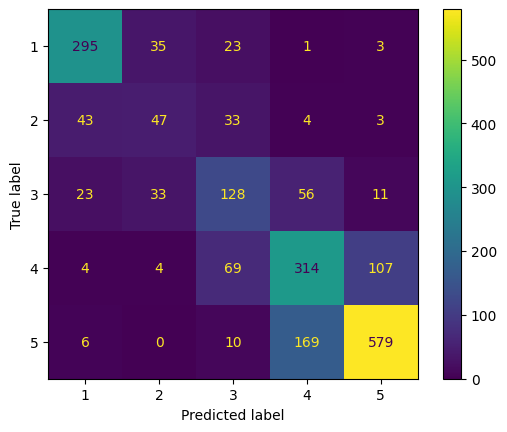

Precision per class:
 [0.79514825 0.39495798 0.48669202 0.57720588 0.82361309]
Recall per class:
 [0.82633053 0.36153846 0.50996016 0.63052209 0.7578534 ]
F1 Score per class:
 [0.81043956 0.37751004 0.49805447 0.60268714 0.78936605]
Weighted F1 Score: 0.6833143809242929


In [26]:
bert_normal = ClassifierHelper('bert-base-uncased', BertTokenizer, BertForSequenceClassification)
bert_normal.load_or_train("./saved/bert_normal.pt", X_train, y_train)
bert_normal_metrics = bert_normal.evaluate(X_test, y_test, "./errors/bert_normal.csv")

using cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


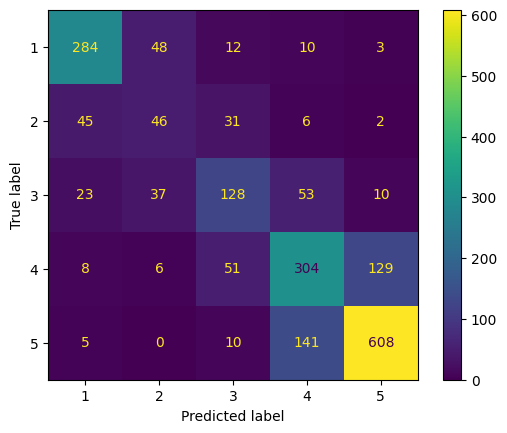

Precision per class:
 [0.77808219 0.33576642 0.55172414 0.59143969 0.80851064]
Recall per class:
 [0.79551821 0.35384615 0.50996016 0.61044177 0.79581152]
F1 Score per class:
 [0.7867036  0.34456929 0.5300207  0.60079051 0.80211082]
Weighted F1 Score: 0.6853443652852775


In [27]:
bert_oversampled = ClassifierHelper('bert-base-uncased', BertTokenizer, BertForSequenceClassification)
bert_oversampled.load_or_train("./saved/bert_oversampled.pt", X_train_oversampled, y_train_oversampled)
bert_oversampled_metrics = bert_oversampled.evaluate(X_test, y_test, "./errors/bert_oversampled.csv")

using cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


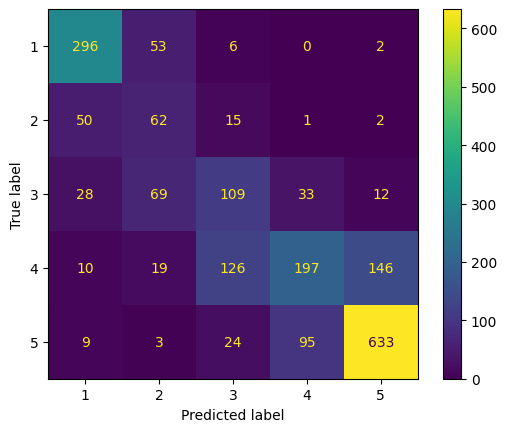

Precision per class:
 [0.75318066 0.30097087 0.38928571 0.60429448 0.79622642]
Recall per class:
 [0.82913165 0.47692308 0.43426295 0.39558233 0.82853403]
F1 Score per class:
 [0.78933333 0.36904762 0.41054614 0.47815534 0.81205901]
Weighted F1 Score: 0.6456748579949364


In [11]:
bert_undersampled = ClassifierHelper('bert-base-uncased', BertTokenizer, BertForSequenceClassification)
bert_undersampled.load_or_train("./saved/bert_undersampled.pt", X_train_undersampled, y_train_undersampled)
bert_undersampled_metrics = bert_undersampled.evaluate(X_test, y_test, "./errors/bert_undersampled.csv")

## Roberta

using cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


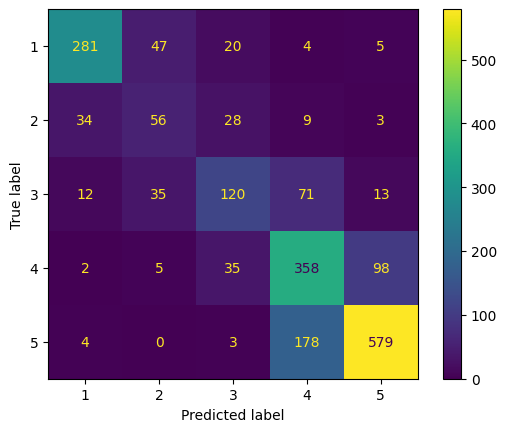

Precision per class:
 [0.84384384 0.39160839 0.58252427 0.57741935 0.82951289]
Recall per class:
 [0.78711485 0.43076923 0.47808765 0.7188755  0.7578534 ]
F1 Score per class:
 [0.81449275 0.41025641 0.52516411 0.64042934 0.79206566]
Weighted F1 Score: 0.6999977081036611


In [29]:
roberta_normal = ClassifierHelper('roberta-base', RobertaTokenizer, RobertaForSequenceClassification)
roberta_normal.load_or_train("./saved/roberta_normal.pt", X_train, y_train)
roberta_normal_metrics = roberta_normal.evaluate(X_test, y_test, "./errors/roberta_normal.csv")

using cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


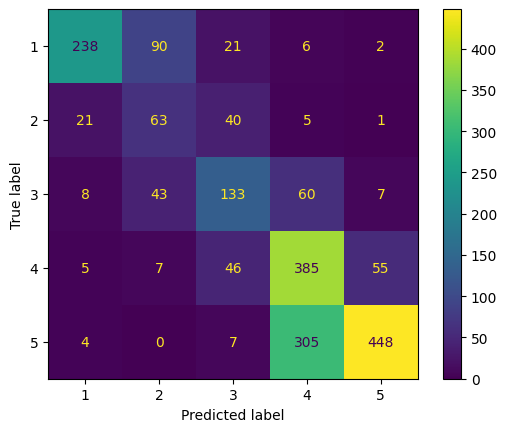

Precision per class:
 [0.86231884 0.31034483 0.53846154 0.50591327 0.87329435]
Recall per class:
 [0.66666667 0.48461538 0.52988048 0.77309237 0.58638743]
F1 Score per class:
 [0.75197472 0.37837838 0.53413655 0.61159651 0.70164448]
Weighted F1 Score: 0.6461719401508091


In [30]:
roberta_oversampled = ClassifierHelper('roberta-base', RobertaTokenizer, RobertaForSequenceClassification)
roberta_oversampled.load_or_train("./saved/roberta_oversampled.pt", X_train_oversampled, y_train_oversampled)
roberta_oversampled_metrics = roberta_oversampled.evaluate(X_test, y_test, "./errors/roberta_oversampled.csv")

using cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


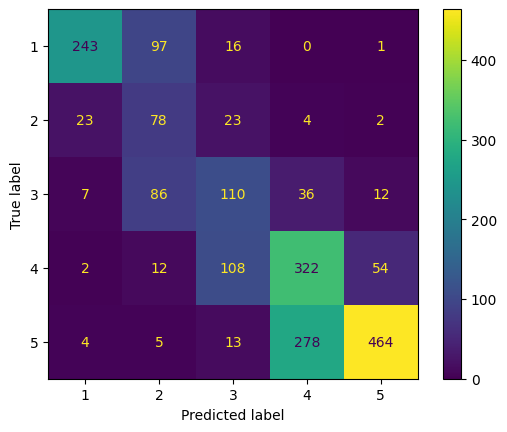

Precision per class:
 [0.87096774 0.28057554 0.40740741 0.503125   0.87054409]
Recall per class:
 [0.68067227 0.6        0.43824701 0.64658635 0.60732984]
F1 Score per class:
 [0.76415094 0.38235294 0.42226488 0.5659051  0.7154973 ]
Weighted F1 Score: 0.6284784646434477


In [31]:
roberta_undersampled = ClassifierHelper('roberta-base', RobertaTokenizer, RobertaForSequenceClassification)
roberta_undersampled.load_or_train("./saved/roberta_undersampled.pt", X_train_undersampled, y_train_undersampled)
roberta_undersampled_metrics = roberta_undersampled.evaluate(X_test, y_test, "./errors/roberta_undersampled.csv")

# New Dataset
Use a new balanced dataset to<> train the model
Use the old dataset as test data.

In [13]:
dataset_b = pd.read_csv("./balanced_reviews.csv")
dataset_b.head()

,ratings,reviews
0,3.0,Coffee Cartel serves it purpose as a place to ...
1,3.0,"Polite service, but baked goods and coffee wer..."
2,3.0,"Serving R.C. isn't cute, or ironic, or vintage..."
3,2.0,It's never good news when I have enough time t...
4,4.0,We normally dine in but due to Covid opted for...


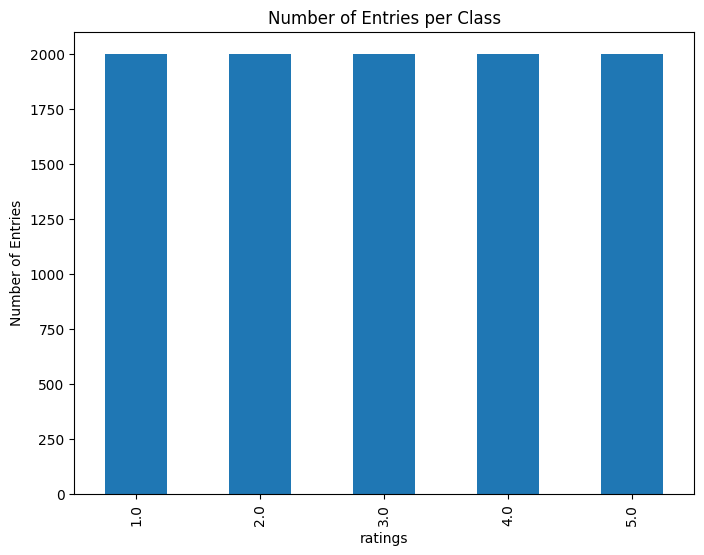

In [13]:
plt.figure(figsize=(8, 6))
dataset_b['ratings'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Entries per Class')
plt.xlabel('ratings')
plt.ylabel('Number of Entries')
plt.show()

### Bert

In [14]:
X_train = dataset_b["reviews"]
X_test = dataset["Review"][:2000]
y_train = [int(float(l)) for l in dataset_b["ratings"]]
y_test = [int(float(l)) for l in dataset["Rating"][:2000]]

In [17]:
bert_new_ds = ClassifierHelper('bert-base-uncased', BertTokenizer, BertForSequenceClassification)
bert_new_ds.load_or_train("./saved/bert_new_ds.pt", X_train, y_train)
bert_new_ds_metrics = bert_new_ds.evaluate(X_test, y_test, "./errors/bert_new_ds.csv")

using cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3:   0%|          | 0/625 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Roberta

In [ ]:
roberta_new_ds = ClassifierHelper('roberta-base', RobertaTokenizer, RobertaForSequenceClassification)
roberta_new_ds.load_or_train("./saved/roberta_new_ds.pt", X_train, y_train)
roberta_new_ds_metrics = roberta_new_ds.evaluate(X_test, y_test, "./errors/roberta_new_ds.csv")